# Thermostat

Example taken from: https://arxiv.org/pdf/1410.8060

```
tOff = ?, tOn = ?

repeat {
    temp = readTemp()
    if isOn() and temp > tOff {
        isOn = False
    }
    else if not isOn() and temp < tOn {
        isOn = True
    }
}
```

Temperature evolves according to:
$$ \frac{d \textit{temp}}{dt} = \begin{cases} - \textit{temp} + 30 \, (+ \text{gauss}(0, \epsilon)) & \text{if isON} \\
                                              - \textit{temp} \, (+ \text{gauss}(0, \epsilon)) & \text{is not isOn}  \end{cases} $$

I generate temperature trajectories for $tOn =, tOff=, k=, h=, \epsilon=$ and try to synthesize $tOn, tOff$ using as loss the log-likelihood over trajectories.

## SOGA

In [4]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']


In [3]:
from optimization import *
torch.set_default_dtype(torch.float64)

Loss value: tensor(2842.0458, grad_fn=<NegBackward0>)


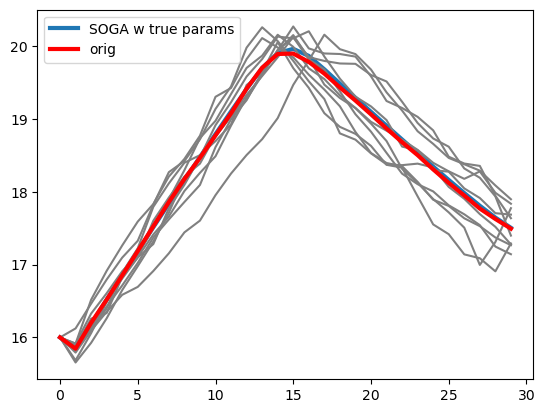

In [ ]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean
orig_params = {'T': 30,   # time steps
               'init_T': 16.,  # initial temperature
               'tOn': 17,      # turn-on temperature
               'tOff': 20}     # turn-off temperature

soga_code = """
array[11] T;
array[11] M; 

/* Initial state */
currT = gauss(30., 1.);   
isOn = 1;                 
tau = 0.;                

dt = 0.03;                
steps = 10;              

for i in range(steps) {

    /* Save current state */
    T[i] = currT;
    M[i] = isOn;

    /* Continuous dynamics */
    if isOn > 0 {
        /* Cooling: dT/dt = -T */
        newT = currT - currT * dt + gauss(0., 0.1);
    } else {
        /* Heating: dT/dt = -(T-30) */
        newT = currT - currT * dt ;
        newT = newT + 30. * dt;
        newT = newT + gauss(0., 0.1);
    } end if;

    currT = newT;
    tau = tau + dt;

    /* Mode switching */
    if isOn > 0 {
        if currT < _tOff {
            isOn = 0;
            tau = 0.;
        } else {
            skip;
        } end if;
    } else {
        if currT >= _tOn {
            isOn = 1;
            tau = 0.;
        } else {
            skip;
        } end if;
    } end if;

} end for;

/* Save final state */
T[steps] = currT;
M[steps] = isOn;

"""

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

# initialize parameters
T = orig_params['T']
init_T = orig_params['init_T']
params = {'tOn':  17., 'tOff':22.}
params_dict = initialize_params(params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# computes loss
idx=list(range(1, T))
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

#plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA w true params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

Loss value: tensor(8708.3595, grad_fn=<NegBackward0>)


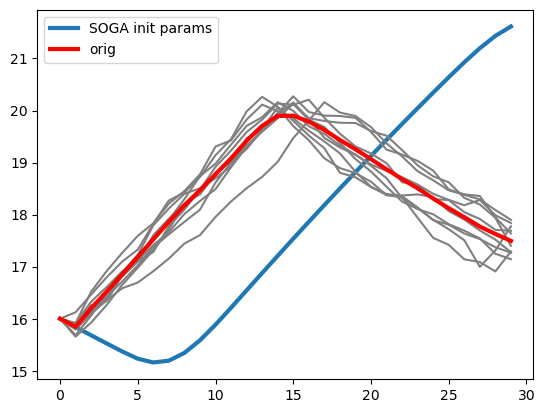

In [4]:
# we choose as initial value of the parameters values for which the loss is higher 
# and there is a significant difference in the mean trajectories

# new cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initial parameters
init_params = {'tOn':  15., 'tOff':22.}
params_dict = initialize_params(init_params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# loss
print('Loss value:', neg_log_likelihood(orig_traj, output_dist, idx))

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

tOn: 15.099999999999723 tOff: 21.90000000000031  loss: 8708.359505278908
tOn: 16.032722443583445 tOff: 20.934294072377156  loss: 3670.906226876693
tOn: 16.493839724613444 tOff: 20.186257888767248  loss: 2900.5551840140433
tOn: 16.672065397713393 tOff: 19.789752937309924  loss: 2858.04197803452
tOn: 16.744874081751153 tOff: 19.74099794173522  loss: 2879.4552005545165
tOn: 16.77675684237539 tOff: 19.868626596689065  loss: 2849.502506054844
tOn: 16.792402360773153 tOff: 19.980351724175513  loss: 2841.7324204565034
tOn: 16.801262070720526 tOff: 20.004445406360908  loss: 2843.2015736799485
tOn: 16.807555936140773 tOff: 19.9753281755339  loss: 2841.816652947523
tOn: 16.813363153312366 tOff: 19.949058374813443  loss: 2841.465564594523
Optimization performed in  295.995
tOn: 16.81881164945195
tOff: 19.945941324442128


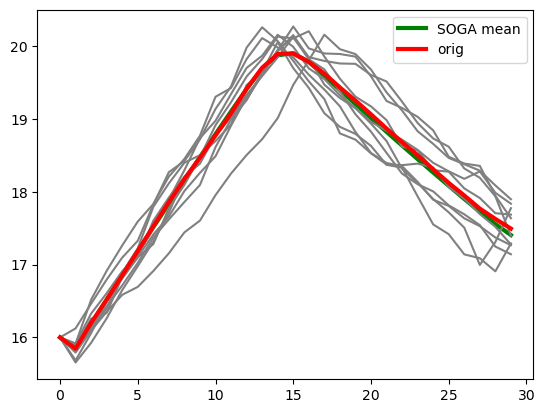

In [5]:
# Optimization in SOGA


# Define the optimizer with init_mean as the parameter
params_dict = initialize_params(init_params)

# Define loss
loss = lambda dist : neg_log_likelihood(orig_traj, dist, idx)

# cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=0.1)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/Thermostat.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

## Pyro estimation

In [2]:
from cps.pyro_models import *

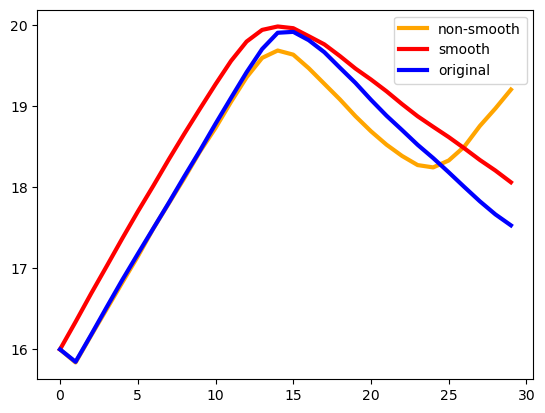

In [3]:
# this is to check that the model I am using are right for the correct parameters

def thermostat_pyro_proof(batch_size=100, k=0.01, h=0.5):

    T = 30
    init_T = 16.
    init_tOn = 17.
    init_tOff = 20.

    tOn = pyro.sample("tOn", dist.Normal(init_tOn, 1.0))
    tOff = pyro.sample("tOff", dist.Normal(init_tOff, 1.0))

    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_T
    isOn = torch.zeros(batch_size, dtype=torch.bool)
    noise = dist.Normal(0.0, 0.1)

    for i in range(1, T):
        traj[:, i] = traj[:, i - 1] - k * traj[:, i - 1] + noise.sample([batch_size])
        traj[:, i] += h * isOn.float()
        isOn = torch.where((isOn & (traj[:, i] > tOff)) | (~isOn & (traj[:, i] < tOn)), ~isOn, isOn)

    return traj

def thermostat_smooth_pyro_proof(batch_size=100, sharpness=5, k=0.01, h=0.5):
        
    T = 30
    init_T = 16.
    init_tOn = 17.
    init_tOff = 20.

    # higher sharpness means sharper transitions 
    tOn = pyro.sample("tOn", dist.Normal(init_tOn, 0.1))
    tOff = pyro.sample("tOff", dist.Normal(init_tOff, 0.1))

    traj = torch.zeros(batch_size, T)
    traj[:, 0] = init_T
    isOn_prob = torch.zeros(batch_size)  # probability that isOn is True
    noise = dist.Normal(0.0, 0.1)

    def sigmoid(x):
        return 1 / (1 + torch.exp(-x))

    for i in range(1, T):
        # Smooth transitions
        turn_on =  sigmoid(sharpness * (tOn - traj[:, i-1]))
        turn_off = sigmoid(sharpness * (traj[:, i-1] - tOff))
        isOn_prob = isOn_prob * (1 - turn_off) + (1 - isOn_prob) * turn_on
        traj[:, i] = traj[:, i-1] - k * traj[:, i-1] + h * isOn_prob + noise.sample([batch_size])

    return traj

plot_traj_set(thermostat_pyro_proof(), single_traj=0, color='orange', label='non-smooth')
plot_traj_set(thermostat_smooth_pyro_proof(), single_traj=0, color='red', label='smooth')
plot_traj_set(orig_traj, single_traj=0, label='original')

### MCMC

In [4]:
### Initial parameters for optimization
init_params = {'T': 30,         # time steps
            'init_T': 16.,    # initial temperature
            'tOn': 15.,       # turn-on temperature
            'tOff': 22.}      # turn-off temperature

### creates Pyro models with the initial parameters
thermostat_pyro = create_thermostat_pyro(init_params, eps=2.0)
thermostat_smooth_pyro = create_thermostat_smooth_pyro(init_params, sharpness=5, eps=2.0)

In [5]:
# Non-smooth models

### runs NUTS to get posterior samples
posterior_samples = run_NUTS(thermostat_pyro, orig_traj, num_samples=100, num_chains=1)

### generate trajectories for posterior estimations and plots the mean trajectory
mcmc_params = {'T': 30,
               'init_T': 16.,
               'tOn': posterior_samples['tOn'].mean().item(),
               'tOff': posterior_samples['tOff'].mean().item()}


mcmc_traj = generate_traj(thermostat_model, 100, mcmc_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plot_traj_set(mcmc_traj, single_traj=0, color='orange', label='mcmc mean')

Warmup:   1%|          | 6/600 [00:00, 13.76it/s, step size=3.44e-03, acc. prob=0.290]

KeyboardInterrupt: 

Warmup:   1%|          | 7/600 [00:20, 13.76it/s, step size=7.07e-04, acc. prob=0.298]

In [6]:
# Smooth model

### runs NUTS to get posterior samples
posterior_samples_smooth = run_NUTS(thermostat_smooth_pyro, orig_traj[:10], num_samples=500, num_chains=1)

### generate trajectories for posterior estimations and plots the mean trajectory
mcmc_smooth_params = {'T': 30,
                      'init_T': 16.,
                      'tOn': posterior_samples_smooth['tOn'].mean().item(),
                      'tOff': posterior_samples_smooth['tOff'].mean().item()}


mcmc_smooth_traj = generate_traj(thermostat_model, 100, mcmc_smooth_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plot_traj_set(mcmc_smooth_traj, single_traj=0, color='orange', ls=':', label='mcmc smooth mean')

Warmup:   2%|▏         | 20/1000 [09:48, 39.10s/it, step size=1.97e-19, acc. prob=0.074]

KeyboardInterrupt: 

### VI Optimization

In [7]:
from cps.pyro_models import *

In [8]:
### Initial parameters for optimization
init_params = {'T': 30,         # time steps
            'init_T': 16.,    # initial temperature
            'tOn': 15.,       # turn-on temperature
            'tOff': 22.}      # turn-off temperature

### creates Pyro models with the initial parameters
thermostat_pyro = create_thermostat_pyro(init_params, eps=2.0)
thermostat_smooth_pyro = create_thermostat_smooth_pyro(init_params, sharpness=5, eps=1.0)

Step 0: Loss = 6981.6009867191315
Step 100: Loss = 8323.47173601389
Step 200: Loss = 7313.782519221306
Step 300: Loss = 6761.12622243166
Step 400: Loss = 6638.9596990942955
Step 500: Loss = 6909.732797205448
Step 600: Loss = 6363.002286732197
Step 700: Loss = 7916.608129560947
Step 800: Loss = 6789.844181895256
Step 900: Loss = 5814.397154092789
Optimization performed in 18.04 seconds
Optimized tOn: 14.546317100524902, tOff: 22.01117515563965


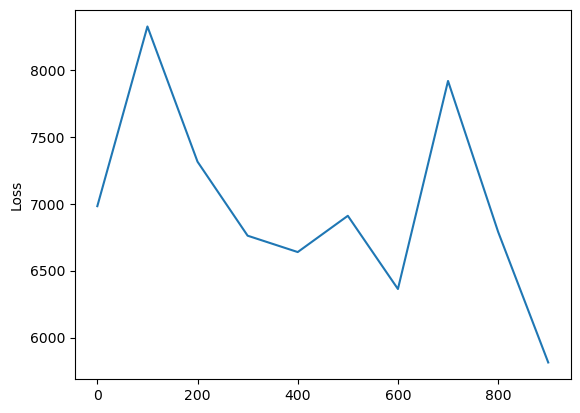

In [12]:
# Non-smooth model

### creates guide
thermostat_guide = create_thermostat_guide(init_params)

### runs SVI to get optimized parameters
run_SVI(thermostat_pyro, thermostat_guide, orig_traj, lr=0.25, num_particles=1, loss_plot=True)

# Retrieve optimized parameters
vi_tOn = pyro.param("tOn_loc").item()
vi_tOff = pyro.param("tOff_loc").item()
print(f"Optimized tOn: {vi_tOn}, tOff: {vi_tOff}")

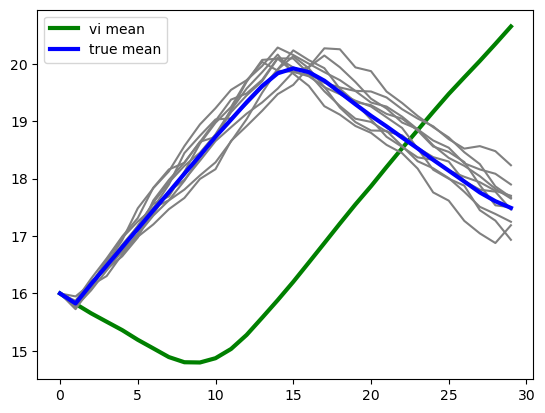

In [13]:
# plot

vi_traj = generate_traj(thermostat_model, 100, {'T': 30, 
                                               'init_T': 16., 
                                               'tOn': vi_tOn, 
                                               'tOff': vi_tOff})
plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')

Step 0: Loss = 6984.087653696537
Step 100: Loss = 3936.268126487732
Step 200: Loss = 4169.199316978455
Step 300: Loss = 3670.756715595722
Step 400: Loss = 3977.779519200325
Step 500: Loss = 4783.663028895855
Step 600: Loss = 3949.6411487460136
Step 700: Loss = 5502.265859484673
Step 800: Loss = 3952.338681578636
Step 900: Loss = 3748.994587123394
Optimization performed in 45.68 seconds
Optimized tOn: 17.104141235351562, tOff: 19.958498001098633


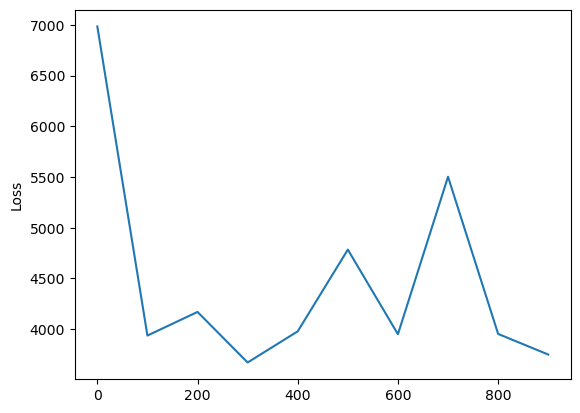

In [17]:
# Smooth model

### creates guide
thermostat_guide = create_thermostat_guide(init_params)

### runs SVI to get optimized parameters
run_SVI(thermostat_smooth_pyro, thermostat_guide, orig_traj, num_particles=1, loss_plot=True)

# Retrieve optimized parameters
vi_tOn = pyro.param("tOn_loc").item()
vi_tOff = pyro.param("tOff_loc").item()
print(f"Optimized tOn: {vi_tOn}, tOff: {vi_tOff}")

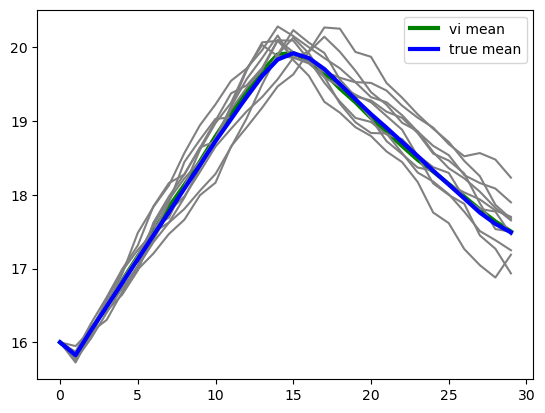

In [19]:
# plot

vi_traj = generate_traj(thermostat_model, 100, {'T': 30, 
                                               'init_T': 16., 
                                               'tOn': vi_tOn, 
                                               'tOff': vi_tOff})
plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')

## Analysis of gradient behaviour

In [46]:
# original model without noise
def det_orig_model(T=10, init_T=17., tOn=16, tOff=20, k=0.01, h=0.5):
    traj = torch.zeros(T)
    isOn = False
    traj[0] = init_T
        
    for i in range(1,T):
        
        #update temperature
        if isOn:
            traj[i] = traj[i-1] -k*traj[i-1] + h 
        else:
            traj[i] = traj[i-1] -k*traj[i-1] 

        # update thermostat state
        if isOn and traj[i] > tOff:
            isOn = False
        elif not isOn and traj[i] < tOn:
            isOn = True
            
    return traj    


# model smoothed with sigmoid (for pyro)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def smooth_orig_model(T=10, init_T=17., tOn=18, tOff=20, k=0.01, h=0.5, eps=0.1, sharpness=1.):
    
    noise = distributions.Normal(torch.tensor(0.), torch.tensor(eps))
    traj = torch.zeros(T)
    isOn = 0.
    traj[0] = init_T
        
    for i in range(1,T):
        
        turn_on = sigmoid(sharpness * (tOn - traj[i-1]))
        turn_off = sigmoid(sharpness * (traj[i-1] - tOff))
        isOn = isOn * (1 - turn_off) + (1 - isOn) * turn_on

        traj[i] = traj[i-1] -k*traj[i-1] + h * isOn + noise.sample()
            
    return traj    

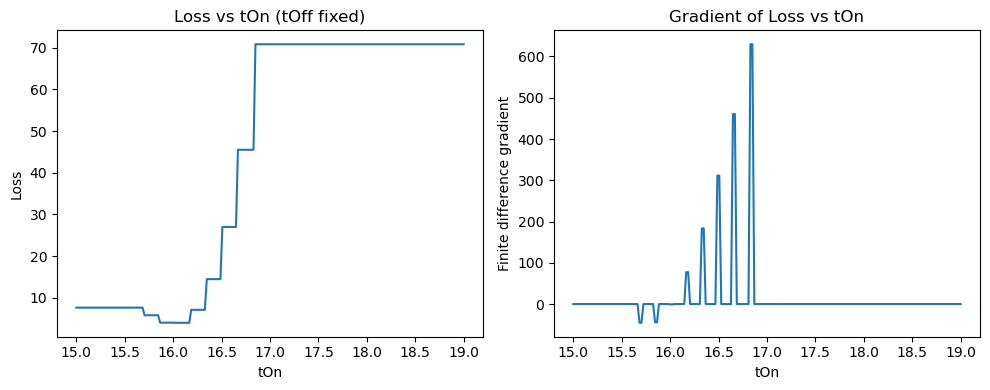

In [47]:
# without noise the model is discontinuous 

import numpy as np
import matplotlib.pyplot as plt


# does it make sense to use this? 
def loss_for_params(model, tOn, tOff, batch_size):
    # Use the original model to generate trajectories with fixed tOn, tOff
    # and compute negative log likelihood on the observed data
    trajs = []
    for _ in range(batch_size):  # use a small batch for speed
        trajs.append(model(tOn=tOn, tOff=tOff))
    trajs = torch.vstack(trajs)
    # Negative log likelihood under the observed data
    # (use the same likelihood as in your SVI)
    with torch.no_grad():
        loss = 0
        for i in range(traj_set.shape[0]):
            loss += -torch.distributions.Normal(trajs.mean(0), 0.5).log_prob(traj_set[i]).sum()
        loss /= traj_set.shape[0]   # added normalization
    return loss.item()

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 200)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(det_orig_model, tOn, tOff_fixed, batch_size=1))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

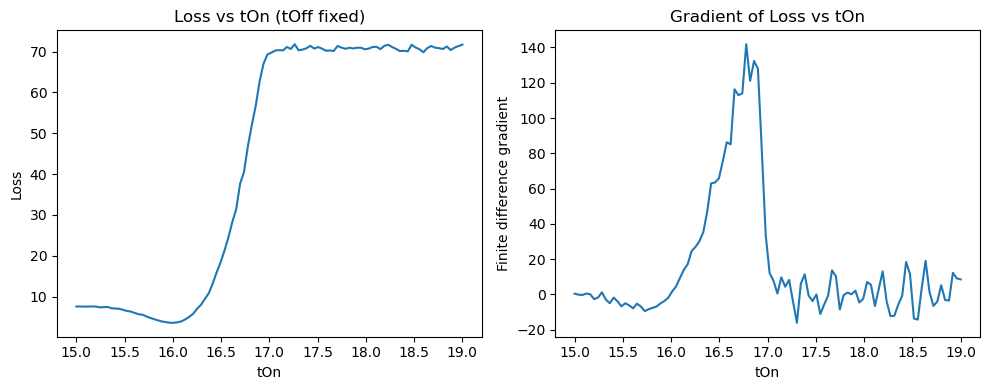

In [48]:
# with noise the loss is continuous but the gradient oscillates a lot

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 100)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(orig_model, tOn, tOff_fixed, batch_size=1000))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)  # finite difference gradient

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()

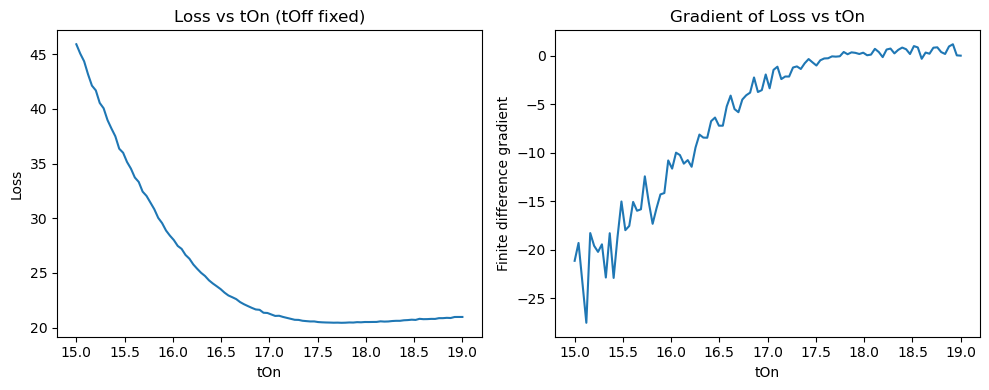

In [ ]:
# with smoothing

# Fix tOff, vary tOn
tOff_fixed = 20.0
tOn_vals = np.linspace(15, 19, 100)
loss_vals = []

for tOn in tOn_vals:
    loss_vals.append(loss_for_params(smooth_orig_model, tOn, tOff_fixed, batch_size=1000))
    # we can use 1 as batch size because the model is deterministic 
    
loss_vals = np.array(loss_vals)
# Finite difference gradient
grad_vals = np.gradient(loss_vals, tOn_vals)  # finite difference gradient

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(tOn_vals, loss_vals)
plt.xlabel("tOn")
plt.ylabel("Loss")
plt.title("Loss vs tOn (tOff fixed)")

plt.subplot(1,2,2)
plt.plot(tOn_vals, grad_vals)
plt.xlabel("tOn")
plt.ylabel("Finite difference gradient")
plt.title("Gradient of Loss vs tOn")

plt.tight_layout()
plt.show()